# Modular MIS solution construction
Step 1: Import full set of points from file. As a future goal, software will be able to automatically incode the relevant graphs efficiently in unit disk graphs [1]. The points below were imported from the applet we wrote to create unit disk graphs.

[1] Ebadi, Sepehr, Alexander Keesling, Madelyn Cain, Tout T. Wang, Harry Levine, Dolev Bluvstein, Giulia Semeghini, et al. “Quantum Optimization of Maximum Independent Set Using Rydberg Atom Arrays.” Science 376, no. 6598 (June 10, 2022): 1209–15. https://doi.org/10.1126/science.abo6587.
]

In [68]:
from braket.ahs.atom_arrangement import AtomArrangement
import numpy as np
from quera_ahs_utils.plotting import show_register
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter
from copy import deepcopy
from braket.aws import AwsDevice
import networkx as nx
import json

#Points imported from graph making tool
points = [
(-4.4869304,-2.8708124),
(-3.7069306,-2.8708124),
(-3.7669306,-2.2148125),
(-4.1069307,-3.5268126),
(-3.0869305,-3.5268126),
(-2.7869306,-2.8708124),
(-2.6469305,-2.2148125),
(-2.1269305,-2.8708124),
(-1.8069305,-3.5268126),
(-1.7869306,-2.2148125),
(-1.2669306,-2.8708124),
(-3.0069306,-1.5588126),
(-2.1069305,-1.5588126),
(-2.6069305,-0.9028125),
(-1.0869305,-1.5588126),
(-0.34693053,-1.5588126),
(-0.60693055,-0.9028125),
(-0.6469305,-2.2148125),
(0.13306946,-2.2148125),
(-3.3669305,-0.9028125),
(-4.4269304,-2.2148125),
(-0.10693054,-0.24681275),
(-0.12693053,0.40918732),
(0.81306946,-0.24681275),
(0.47306946,1.0651873),
(1.0330695,0.40918732),
(1.2530694,-0.9028125),
(1.6330695,-0.24681275),
(1.9130695,0.40918732),
(1.5130695,1.0651873),
(2.3530695,-0.24681275),
(2.5530694,1.0651873),
(3.1330695,0.40918732),
(3.5130694,1.0651873),
(-0.24693054,1.0651873),
(0.63306946,1.7211871),
(1.3930695,1.7211871),
(1.7130694,2.3771875),
(2.4730694,2.3771875),
(3.1330695,2.3771875),
(3.4130695,1.7211871),
(-0.06693054,2.3771875),
(0.53306943,3.0331872),
(2.0530694,3.0331872),
(3.0330694,3.0331872),
(3.8330696,2.3771875),
(4.3330693,1.7211871),
(4.2930694,1.0651873),
(-0.32693055,3.0331872),
(1.0130695,2.3771875),
(-1.0669305,1.0651873),
(-2.0069306,1.0651873),
(-1.9469305,1.7211871),
(-2.6269305,1.7211871),
(-1.1269306,1.7211871),
(-1.5669305,0.40918732),
(-2.4269304,0.40918732),
(-3.0469306,1.0651873),
(-3.1469305,0.40918732),
(-3.3869305,1.7211871),
(-2.6869307,2.3771875),
(-3.5269306,2.3771875),
(-3.7269306,1.0651873),
(-2.6069305,3.0331872),
(-2.2869306,3.689187),
(-2.9469306,3.689187),
(-3.8269305,3.0331872),
(-4.6269307,3.0331872),
(-4.0469303,3.689187),
(-4.5469303,2.3771875),
(-4.4869304,1.0651873),
(-4.7669306,0.40918732),
(-5.3869305,1.0651873),
(-1.3669305,3.689187),
(-1.2269305,3.0331872),
(-2.2869306,4.345187),
(-1.6069305,4.345187),
(-1.9269305,2.3771875),
(2.8130693,-0.9028125),
(2.4330695,-1.5588126),
(3.1530695,-1.5588126),
(2.3330696,-2.2148125),
(3.2530694,-2.2148125),
(4.0330696,-1.5588126),
(4.0930696,-2.2148125),
(3.4730694,-2.8708124),
(2.6330695,-2.8708124),
(3.9330695,-0.9028125),
(4.6930695,-1.5588126),
(4.7730694,-2.2148125),
(4.6530695,-2.8708124),
(3.9730694,-3.5268126),
(3.1330695,-3.5268126),
(1.8930695,-2.8708124),
(1.2530694,-3.5268126),
(2.0930696,-3.5268126),
(5.3130693,-3.5268126),
(5.5730696,-2.8708124),
(4.7130694,-0.9028125),
(5.1530695,-0.24681275)
]

## Unit disk graphs
The graph-making program exports unit disk graphs as a list of points without an adjacency list, so the following methods parse these points to create a unit-disk graph representation.

In [77]:
def points_to_unit_graph(atom_list, scale=1):
    """Populate the connections of a unit disk graph given a list of points

    Args:
        atom_list (list[tuple]): list of x,y coordinates.
        scale (int, optional): scale to use for unit distance. Defaults to 1.

    Returns:
        graph : graph generated from the x,y coords
    """
    edge_dict = {}
    for i in range(len(atom_list)):
        for j in range(len(atom_list)):
            if(j == i):
                continue
            if np.sqrt((atom_list[i][0]-atom_list[j][0])**2 + (atom_list[i][1]-atom_list[j][1])**2) <= scale:
                if(i in edge_dict):
                    edge_dict[i].append(j)
                else:
                    edge_dict[i] = [j]
    return nx.from_dict_of_lists(edge_dict)

def plot_graph(point_list, plot = True):
    """Method to generate AtomArrangement from a list of points

    Args:
        point_list (tuple) : a list of x and y coordinates in units of 1e-6

    Returns:
        graph
    """
    atoms = AtomArrangement()
    for atom in points:
        atoms.add(atom)
    graph = points_to_unit_graph(scale=1, atom_list=point_list)

    if plot:
        fig, ax = plt.subplots()
        pos = {ii: (point_list[ii][0],point_list[ii][1]) for ii in graph.nodes()}

        nx.draw(graph, pos=pos, with_labels=True)
        plt.show()
    return graph

Plot graph

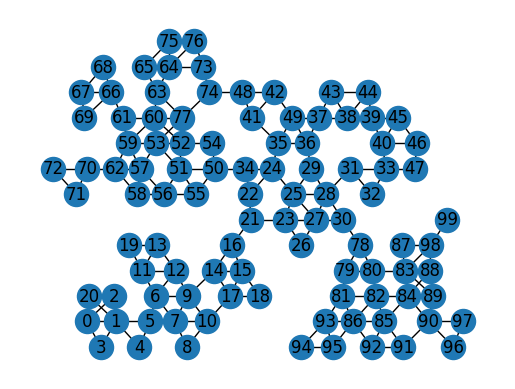

In [78]:
plot_graph(points);

## Clustering graph
For many relevant examples, such as distribution networks, ecosystems, and stock portfolios, graphs consist of dense clusters of nodes. A future goal would be to carry out this clustering automatically. There are known algorithms such as HCS which are capable of performing cluster analysis [2].

[2] Hartuv, Erez, and Ron Shamir. “A Clustering Algorithm Based on Graph Connectivity.” Information Processing Letters 76 (December 1, 2000): 175–81. https://doi.org/10.1016/S0020-0190(00)00142-3.

In [79]:
points1 = points[:21]
points2 = points[21:50]
points3 = points[50:78]
points4 = points[78:]

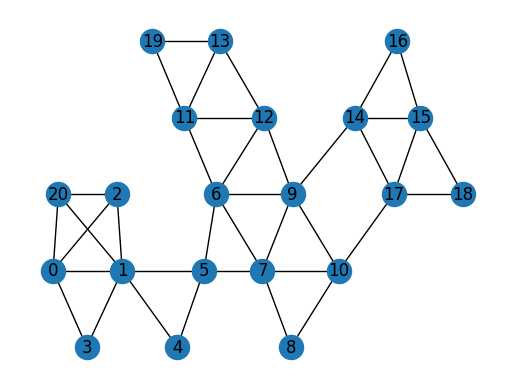

In [27]:
plot_graph(points1);

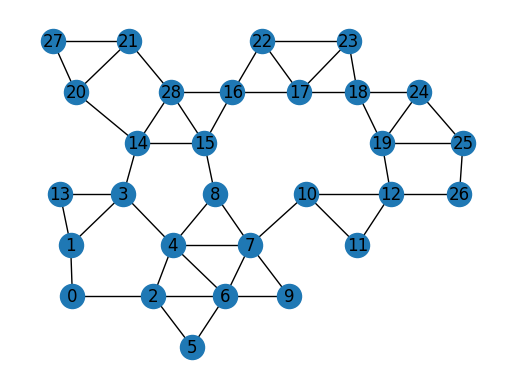

In [28]:
#points2.append((points2[0][0]-.9, points2[0][1]))
#points2.append((points2[0][0], points2[0][1]-.656))
plot_graph(points2)
#Connected to cluster 1 by 0-16

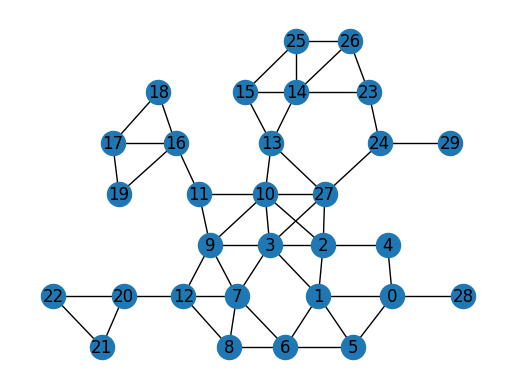

In [43]:
points3.append((points3[0][0]+.9, points3[0][1]))
points3.append((points3[24][0]+.9, points3[24][1]))

plot_graph(points3)
#connected to cluster 2 by 0 and 24

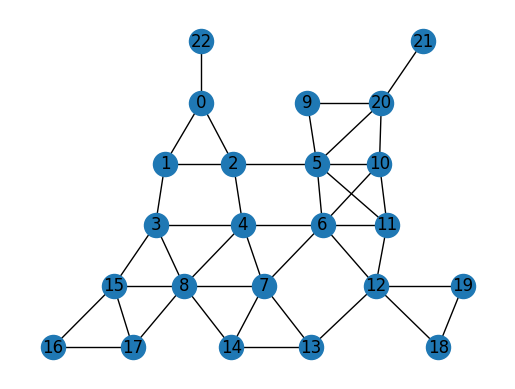

In [80]:
#connected to cluster 2 by 0
points4.append((points4[0][0], points4[0][1]+.656))

plot_graph(points4)

In [52]:
def find_UDG_radius(position, graph):
    """Code borrowed from 'Maximum Independent Sets with Analog Hamiltonian Simulation'

    Args:
        position (list[tuple]): a list of x,y coordinates of points
        graph (Graph): the unit graph representation of the coordinates

    Raises:
        Exception: If a graph created with the graph maker program is not a unit disk graph,
        then something has gone horribly wrong!

    Returns:
        tuple[int]: The geometric mean, the min, and the max radius
    """
    
    dists = [[np.sqrt((x0-x1)**2+(y0-y1)**2) for (x0,y0) in position] for (x1,y1) in position]
    rmin = 0
    rmax = np.inf
    for i in range(len(position)):
        for j in range(i+1,len(position)):
            if (i,j) in graph.edges:
                if rmin<dists[i][j]:
                    rmin = dists[i][j]
            elif (i,j) not in graph.edges:
                if rmax>dists[i][j]:
                    rmax = dists[i][j]
    
    if rmin>rmax:
        print(rmin,rmax)
        raise BaseException("Graph is not a unit disk graph!")
    
    return np.sqrt(rmin*rmax),rmin,rmax

# Find unit disk radius
graph = plot_graph(points3, plot = False)

In [53]:
unitdisk_radius,min_radius,max_radius = find_UDG_radius(points3,graph)
unitdisk_radius

1.0043329740316287

In [54]:
Delta_final = 20e6 # rad/sec

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Capabilities, constraints and performance metrics are stored as 'paradigm' attribute of AwsDevice.
capabilities = qpu.properties.paradigm

# get C6 coefficient in rad m^6/sec Pull from capabilities attribute
C6 = float(capabilities.rydberg.dict()['c6Coefficient'])

# Find blockade radius
blockade_radius = (C6/(Delta_final))**(1/6)
print('Blockade radius of Rydberg system is {:0.3e}m'.format(blockade_radius))
print('Unit disk radius of logical graph is {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
a = blockade_radius / unitdisk_radius


# Generate the atom register
from braket.ahs.atom_arrangement import AtomArrangement
register = AtomArrangement()
for (x,y) in points3:
    register.add([round(a * x, 7), round(a * y, 7)])
    
show_register(register, blockade_radius = a)

NoRegionError: You must specify a region.

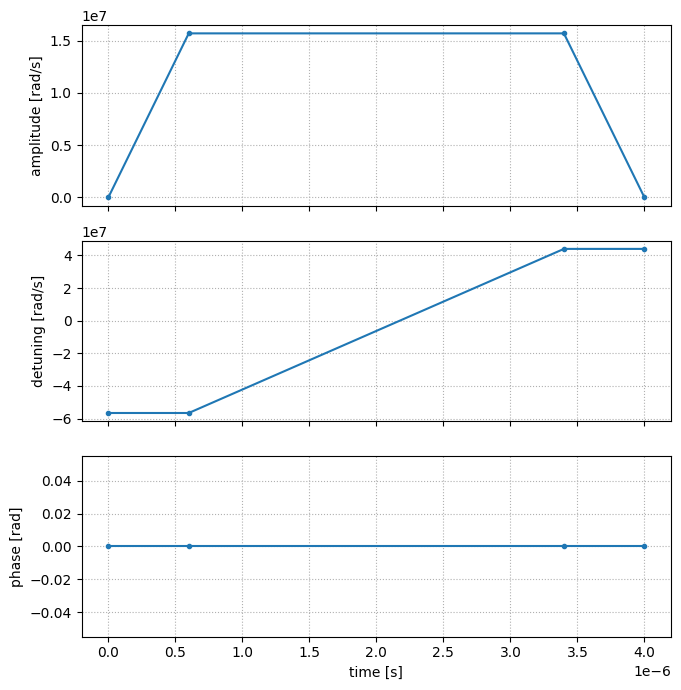

In [13]:
from braket.ahs.hamiltonian import Hamiltonian

H = Hamiltonian()

from quera_ahs_utils.plotting import show_global_drive 
from quera_ahs_utils.drive import get_drive

omega_min = 0.0      
omega_max = 2.5e6 * 2 * np.pi
detuning_min = -9e6 * 2 * np.pi
detuning_max = 7e6 * 2 * np.pi

time_max = 4e-6
time_ramp = 0.15*time_max

time_points = [0.0, time_ramp, time_max - time_ramp, time_max]
time_points = [(t*1e+9 - (t*1e+9 % 1))/1e+9 for t in time_points]
omega_values = [omega_min, omega_max, omega_max, omega_min]
omega_values = [o-(o%400) for o in omega_values]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
detuning_values = [(dt*10-((dt*10)%2))/10 for dt in detuning_values]
phase_values = [0.0, 0.0, 0.0, 0.0]

drive = get_drive(time_points, omega_values, detuning_values, phase_values)
H += drive

show_global_drive(drive)
plt.show()

### Defining the program (1D case)

In [14]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=H
)

NameError: name 'register' is not defined

In [55]:
def save_result_json(json_file,result):
    '''
    Helper function to save results locally
    '''
    result_dict = {"measurements":[]}
    for measurement in result.measurements:
        shot_result = {
            "pre_sequence":[int(qubit) for qubit in measurement.pre_sequence],
            "post_sequence":[int(qubit) for qubit in measurement.post_sequence]
                      } 
        result_dict["measurements"].append(shot_result)
        
    with open(json_file,"w") as io:
        json.dump(result_dict,io,indent=2)
        
def open_json(json_file):
    '''
    Helper function to load and open json data
    '''
    with open(json_file,"r") as io:
        return json.load(io) 

In [182]:
raise BaseException("Only run this cell when you are ready to submit your job.")


nshots = 15
task = qpu.run(ahs_program, shots=nshots)
task_arn = task.id
print(task_arn)

arn:aws:braket:us-east-1:592242689881:quantum-task/3728ec59-4a0c-49be-becc-0aa638348f8b


In [37]:
# Next, load the task given the ARN.
from braket.aws import AwsSession, AwsQuantumTask
task = AwsQuantumTask(arn = "arn:aws:braket:us-east-1:592242689881:quantum-task/7a4fd370-a75f-4aa1-a01f-52f9f0dd77b0")

In [38]:
result = task.result()

NoCredentialsError: Unable to locate credentials

In [193]:
save_result_json("../data/cluster_3_fifteen_shots.json",task.result())

In [72]:
result = open_json("../data/cluster_4_fifteen_shots.json")

In [81]:
def check_graph(graph_dict):
    for vertex in graph_dict:
        # Check for ground state atoms that could be Rydberg
        if(graph_dict[vertex][0] == 1):
            fail = True
            for a in graph_dict[vertex][1]:
                if(graph_dict[a][0] == 0):
                    fail = False
            if(fail):
                # print("DEATH")
                return False
            
        # Check for adjacent Rydberg atoms
        elif(graph_dict[vertex][0] == 0):
            # print(graph_dict[vertex])
            for a in graph_dict[vertex][1]:
                if(graph_dict[a][0] == 0):
                    # print("DEATH")
                    return False
    return True

def postprocessing(graph_dict):
    if(check_graph(graph_dict)):
        return graph_dict
    for vertex in graph_dict:
        # Check for adjacent Rydberg atoms and set them both to ground
        if(graph_dict[vertex][0] == 0):
            for a in graph_dict[vertex][1]:
                if(graph_dict[a][0] == 0):
                    graph_dict[vertex][0] = 1
                    graph_dict[a][0] = 1
                    break
    available_vertices = []
    for vertex in graph_dict:    
        if(graph_dict[vertex][0] == 1):
            available = True
            for a in graph_dict[vertex][1]:
                if(graph_dict[a][0] == 0):
                    available = False
            if(available):
                available_vertices.append(vertex)
                
    # Discard sufficienly bad graphs that become computationally intractable
    if(len(available_vertices) > 10):
        print("Intractable")
        return None
    
    for bits in product([0,1], repeat=len(available_vertices)):
        test_graph = graph_dict
        for vertex in range(len(available_vertices)):
            test_graph[available_vertices[vertex]][0] = bits[vertex]
        if(check_graph(test_graph)):
            return test_graph
        # else:
            # print(test_graph)
        # print(test_graph)

    return None

In [82]:
graph = plot_graph(points4, plot = False);

In [83]:
i = 0
post_process_result = deepcopy(result)
# print(final_registers.measurements)
bad_measurements = []
for shot in post_process_result["measurements"]:
    colored_graph = nx.to_dict_of_dicts(graph)
    for s in range(len(shot["post_sequence"])): 
        colored_graph[s] = [shot["post_sequence"][s] if shot["pre_sequence"][s] == 1 else 2 ,colored_graph[s]]
    clean_graph = postprocessing(colored_graph)
    if(clean_graph == None):
        bad_measurements.append(i)
    else:
        for vertex in clean_graph:
            post_process_result["measurements"][i]["post_sequence"][vertex] = clean_graph[vertex][0]
    i = i+1
len(bad_measurements)

0

In [84]:
final_results = []
for i,result in enumerate(post_process_result['measurements']):
    if not i in bad_measurements:
        final_results.append(result)

Independent set of 0-th most likely outcome


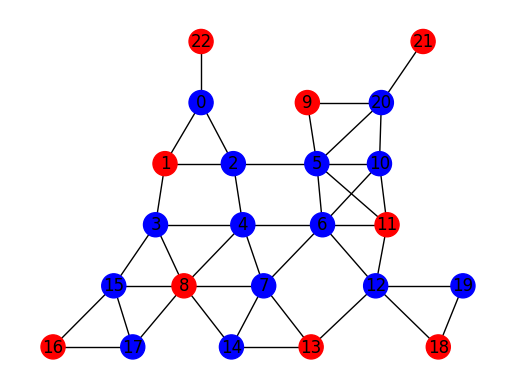

Independent set of 1-th most likely outcome


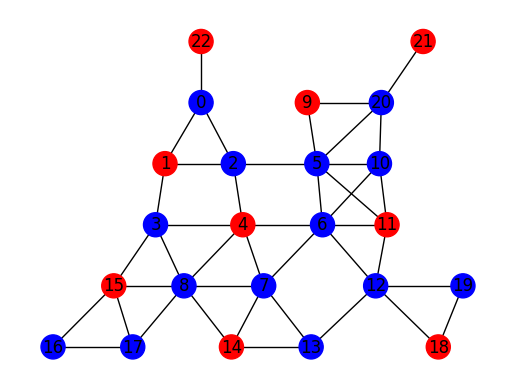

Independent set of 2-th most likely outcome


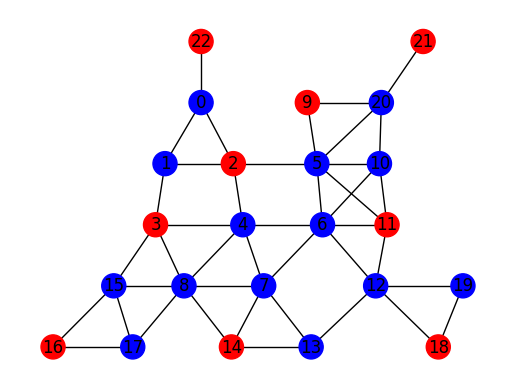

Independent set of 3-th most likely outcome


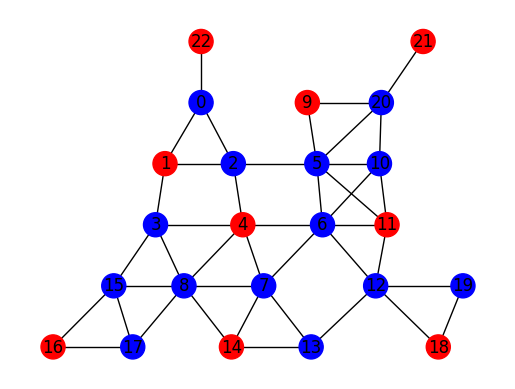

Independent set of 4-th most likely outcome


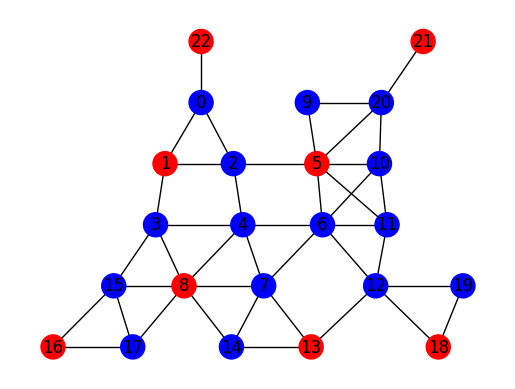

In [86]:
states = ['e', 'r', 'g']
state_labels = []
for shot in final_results:
    pre = shot['pre_sequence']
    post = shot['post_sequence']
    state_idx = np.array(pre) * (1 + np.array(post))
    state_labels.append("".join([states[s_idx] for s_idx in state_idx]))

occurence_count = Counter(state_labels)

most_frequent_regs = occurence_count.most_common(5)

most_frequent_regs = occurence_count.most_common(5)
for ii in range(len(most_frequent_regs)):
    fig, ax = plt.subplots()
    vert_colors = ['red' if (most_frequent_regs[ii][0][i] == 'r') else 'blue' for i in range(len(most_frequent_regs[ii][0]))]
    print(f'Independent set of {ii}-th most likely outcome')
    nx.draw(graph, pos = {ii: points4[ii] for ii in graph.nodes()}, ax=ax, with_labels=True, node_color=vert_colors)
    plt.show()

In [166]:
occurence_count

Counter({'rggrggrrr': 19, 'rgggrggrr': 1})